In [1]:
# SomeOtherFile.py
from py_grpc_server.loadPlayers import load_all_players
from py_grpc_server.agent_pb2 import Player, DraftStatus, FantasyTeam, GameState, DraftStatus
from typing import List

In [2]:
def is_available(player: Player) -> bool:
    return player.draft_status.availability == DraftStatus.Availability.AVAILABLE

def init_team(id: str, name: str, owner: str) -> FantasyTeam:
    team = FantasyTeam()
    team.id = id
    team.name = name
    team.owner = owner
    return team

In [3]:
# Load players from a specified CSV file
players = load_all_players('./player_ranks.csv')
teams = [
    init_team("1", "A", "Alex"),
    init_team("2", "B", "Bob"),
    init_team("3", "C", "Chris"),
    init_team("4", "D", "Darrell"),
    init_team("5", "E", "Emma"),
    init_team("6", "F", "Frank"),
    init_team("7", "G", "Gillian"),
    init_team("8", "H", "Helen"),
    init_team("9", "J", "Jim"),
    init_team("10", "K", "Kevin")
]
game_state = GameState()
game_state.players.extend(players)
game_state.teams.extend(teams)
game_state.current_pick = 1
game_state.total_rounds = 16
game_state.drafting_team_id = teams[0].id

In [25]:
def draft_player(players: List[Player]) -> str:
    """
    Selects a player to draft based on the highest rank.

    Args:
        players (List[Player]): A list of Player objects.

    Returns:
        str: The id of the drafted player.
    """
    # Filter out already drafted players
    undrafted_players = [player for player in players if is_available(player)]

    # Select the player with the highest rank (lowest rank number)
    if undrafted_players:
        drafted_player = min(undrafted_players, key=lambda p: p.rank)
        return drafted_player.id
    else:
        return ""  # Return empty string if no undrafted players are available

In [59]:
def get_picking_team_index(game_state: GameState, pick: int) -> int:
    number_of_teams = len(game_state.teams)
    # Adjust pick to be zero-based for easier modulo calculations
    pick_adjusted = pick - 1
    
    # Determine the round of the pick
    round_number = pick_adjusted // number_of_teams
    
    # Determine position within the round
    position_in_round = pick_adjusted % number_of_teams
    
    # If the round number is even, order is straightforward
    # If the round number is odd, order is reversed
    if round_number % 2 == 1:
        position_in_round = number_of_teams - 1 - position_in_round
    return position_in_round

def get_picking_team_id(game_state: GameState, pick: int) -> int:
    return game_state.teams[get_picking_team_index(game_state, pick)].id

In [60]:
total_picks = game_state.total_rounds * len(game_state.teams)
while game_state.current_pick <= total_picks:
    player_id = draft_player(game_state.players)
    for player in game_state.players:
        if player.id == player_id:
            player.draft_status.availability = DraftStatus.DRAFTED
            player.draft_status.pick_chosen = game_state.current_pick
            player.draft_status.team_id_chosen = game_state.drafting_team_id 
    # update for next pick
    game_state.current_pick += 1
    game_state.drafting_team_id = get_picking_team_id(game_state, game_state.current_pick)

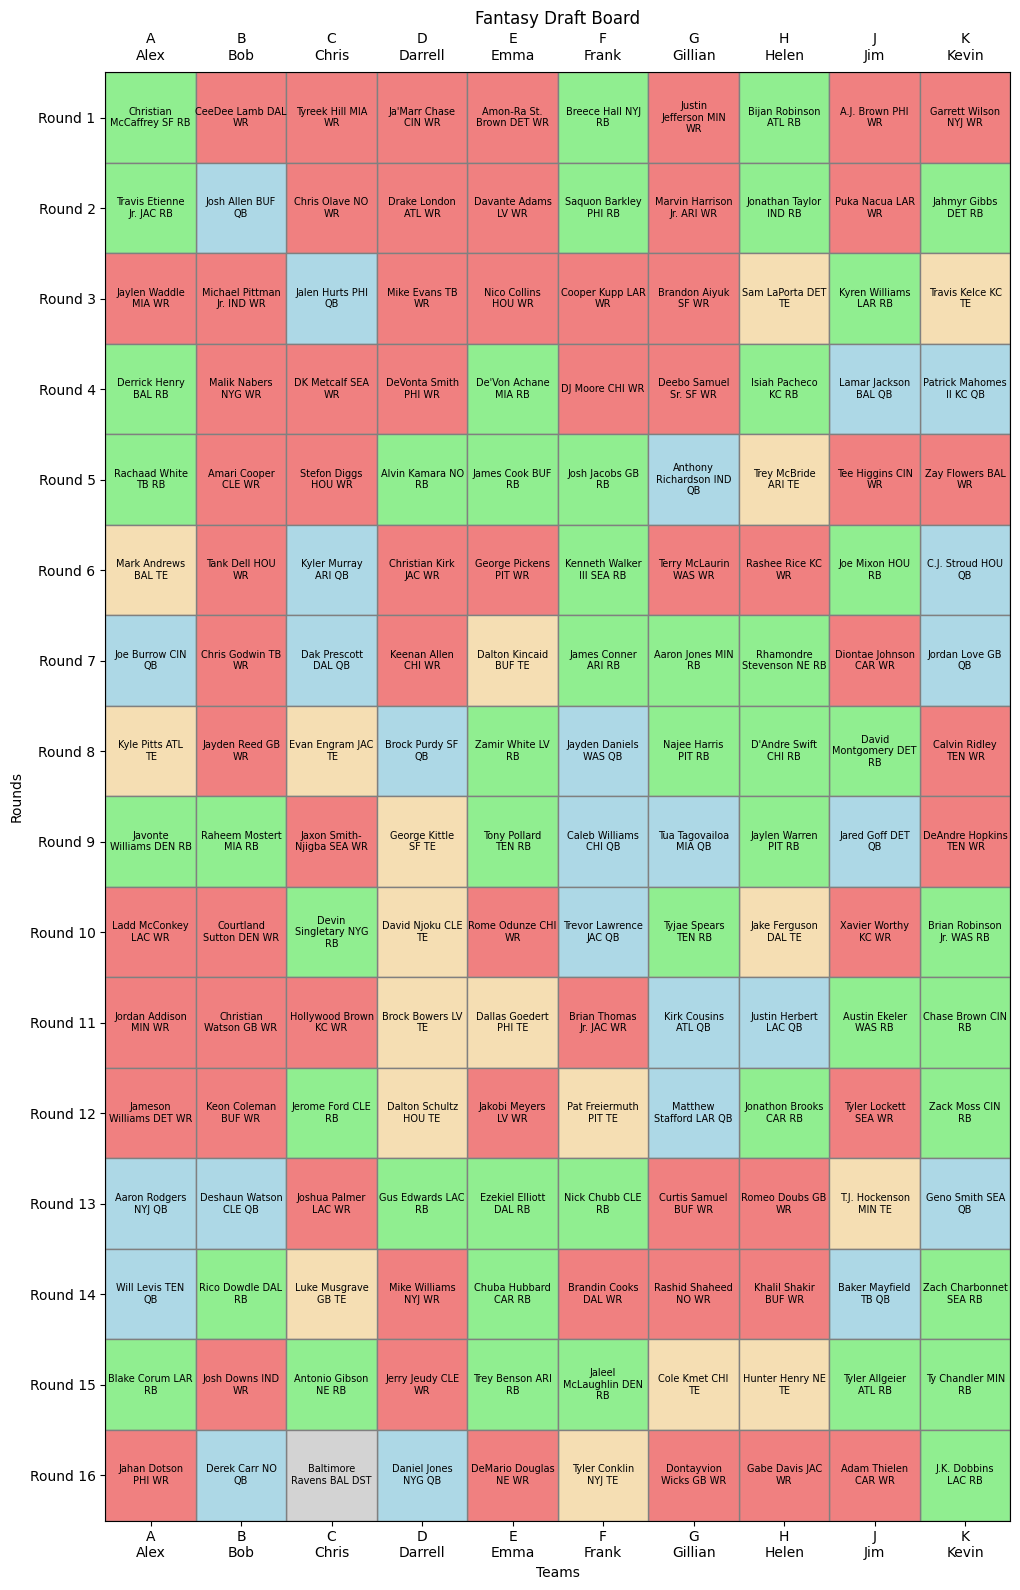

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import textwrap

def wrap_text(text, width):
    """Wrap text to fit within a given width."""
    return '\n'.join(textwrap.wrap(text, width))

# Position-based color configuration (you can customize this)
position_colors = {
    'QB': 'lightblue',
    'RB': 'lightgreen',
    'WR': 'lightcoral',
    'TE': 'wheat',
    'DEF': 'lavender'
}

# Get the number of teams and prepare the board layout
num_teams = len(game_state.teams)
num_rounds = game_state.total_rounds

fig, ax = plt.subplots(figsize=(20, num_rounds )) 
ax.set_xlim(0, num_teams)
ax.set_ylim(0, num_rounds)
ax.set_aspect('equal')  # This makes each box have equal width and height

# Use a smaller font size if needed
font_size = 7

# Plotting each player
for player in game_state.players:
    if player.draft_status.availability != DraftStatus.Availability.DRAFTED:
        continue
    round_number = (player.draft_status.pick_chosen - 1) // num_teams
    team_index = get_picking_team_index(game_state, player.draft_status.pick_chosen)

    # Determine the color based on the first allowed position (assuming the position list is not empty)
    position_color = position_colors.get(player.allowed_positions[0], 'lightgrey')  # Default to lightgrey if no match

    # Create a rectangle for each pick
    rect = patches.Rectangle((team_index, round_number), 1, 1, linewidth=1, edgecolor='gray', facecolor=position_color)
    ax.add_patch(rect)

    # Add player info text over the rectangle
    player_info = f"{player.full_name}\n{player.professional_team}\n{player.allowed_positions[0]}"
    wrapped_text = wrap_text(player_info, 15)
    ax.text(team_index + 0.5, round_number + 0.5, wrapped_text, ha='center', va='center', fontsize=font_size)

# Set the grid and labels
ax.set_xticks([i + 0.5 for i in range(num_teams)])
ax.set_yticks([i + 0.5 for i in range(num_rounds)])
ax.set_xticklabels([f"{team.name}\n{team.owner}" for team in game_state.teams], rotation=0)
ax.set_yticklabels([f"Round {i+1}" for i in range(num_rounds)])
ax.xaxis.set_tick_params(labeltop=True)  # Display team names at the top

plt.gca().invert_yaxis()  # Ensure that the first round starts at the top
plt.title('Fantasy Draft Board')
plt.xlabel('Teams')
plt.ylabel('Rounds')
plt.tight_layout()
plt.show()


In [14]:
import nfl_data_py as nfl
import pandas as pd
pd.set_option('display.max_columns', None)

In [68]:
df = nfl.import_pbp_data([2023], downcast=True, cache=False, alt_path=None)

2023 done.
Downcasting floats.


In [7]:
weekly_df = nfl.import_weekly_data([2023])

Downcasting floats.


In [15]:
player = game_state.players[0]
player_stats = weekly_df[(weekly_df.player_id == player.id) & (weekly_df.season_type == 'REG')]
player_stats["

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,opponent_team,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
914,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,1,REG,PIT,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,22,152.0,1,0.0,0.0,7.0,3.150328,0,3,5,17.0,0,1.0,0.0,12.0,8.0,1.0,-0.809597,0,1.416667,0.178571,0.052174,0.304379,0.0,22.900000,25.900000
915,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,2,REG,LA,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,20,116.0,1,0.0,0.0,4.0,-0.373122,0,3,3,19.0,0,0.0,0.0,1.0,18.0,0.0,0.672484,0,19.000000,0.125000,0.004444,0.190611,0.0,19.500000,22.500000
916,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,3,REG,NYG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,18,85.0,1,0.0,0.0,4.0,1.910523,0,5,5,34.0,0,0.0,0.0,-11.0,45.0,3.0,4.003596,0,-3.090909,0.147059,-0.069182,0.172161,0.0,17.900000,22.900000
917,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,4,REG,ARI,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,20,106.0,3,0.0,0.0,8.0,2.987022,0,7,8,71.0,1,0.0,0.0,17.0,56.0,7.0,7.398638,0,4.176471,0.380952,0.093923,0.637174,0.0,41.700001,48.700001
918,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,5,REG,DAL,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,19,51.0,1,1.0,1.0,5.0,-5.274155,0,2,3,27.0,0,0.0,0.0,-4.0,29.0,1.0,0.371709,0,-6.750000,0.120000,-0.018957,0.166730,0.0,11.800000,13.800000
919,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,6,REG,CLE,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,11,43.0,0,0.0,0.0,2.0,-0.431987,0,3,3,9.0,1,0.0,0.0,-9.0,18.0,1.0,-0.015573,0,-1.000000,0.125000,-0.037500,0.161250,0.0,11.200000,14.200000
920,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,7,REG,MIN,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,15,45.0,1,1.0,1.0,4.0,-6.000253,0,3,3,51.0,1,0.0,0.0,-1.0,52.0,2.0,4.008349,0,-51.000000,0.103448,-0.004149,0.152268,0.0,19.600000,22.600000
921,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,8,REG,CIN,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,12,54.0,1,0.0,0.0,4.0,-0.801738,0,6,7,64.0,1,0.0,0.0,22.0,42.0,3.0,2.067866,0,2.909091,0.233333,0.084942,0.409459,0.0,23.799999,29.799999
922,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,10,REG,JAX,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,16,95.0,0,0.0,0.0,6.0,3.356684,0,6,10,47.0,0,0.0,0.0,0.0,51.0,2.0,-1.869345,0,0.000000,0.370370,0.000000,0.555556,0.0,14.200000,20.200001
923,00-0033280,C.McCaffrey,Christian McCaffrey,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SF,2023,11,REG,TB,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,21,78.0,0,0.0,0.0,4.0,-5.436401,0,5,5,25.0,1,0.0,0.0,8.0,17.0,2.0,2.288877,0,3.125000,0.200000,0.039801,0.327861,0.0,16.299999,21.299999


In [16]:
season_df = nfl.import_seasonal_data([2023])


In [18]:
player_df = season_df[(season_df.player_id == player.id)]

In [19]:
player_df

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr_x,special_teams_tds,fantasy_points,fantasy_points_ppr,games,tgt_sh,ay_sh,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
102,00-0033280,2023,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,272,1459.0,14,2.0,2.0,83.0,14.388324,0,67,83,564.0,7,1.0,0.0,153.0,461.0,31.0,6.454787,0,-17.937129,2.985537,0.697468,4.966534,0.0,324.3,391.3,16,0.178495,0.040627,0.219419,0.300243,0.128532,0.21875,0.15736,0.165939,0.173641,0.146576,1.212903,0.245065


In [20]:
season_df

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr_x,special_teams_tds,fantasy_points,fantasy_points_ppr,games,tgt_sh,ay_sh,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0023459,2023,REG,0,1,0.0,0,0.0,1.0,10.0,0,0,17.0,0.0,0.0,-2.031960,0,0.000000,0.000000,0,0.0,0,0.0,0.0,0.0,0.000000,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,00-0024243,2023,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0,0.0,0,0.0,0.0,0.0,0.000000,0,4,5,29.0,1,0.0,0.0,9.0,29.0,2.0,2.486083,0,4.200000,0.187999,0.109687,0.358779,0.0,8.90,12.90,5,0.034014,0.007902,0.069712,0.057342,0.027384,0.125,0.036364,0.047619,0.076192,0.046907,0.197279,0.028467
2,00-0026158,2023,REG,123,204,1616.0,13,8.0,8.0,57.0,3,1,1910.0,678.0,60.0,-1.607587,1,4.883885,0.367874,9,2.0,0,1.0,0.0,3.0,-0.469946,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,100.84,100.84,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191464
3,00-0026498,2023,REG,326,521,3965.0,24,11.0,30.0,205.0,0,0,4033.0,1890.0,187.0,55.032108,1,15.714152,1.287110,21,65.0,0,0.0,0.0,4.0,3.965635,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.0,243.10,243.10,15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173299
4,00-0026625,2023,REG,23,42,231.0,0,2.0,1.0,8.0,0,0,344.0,80.0,14.0,-8.780773,0,1.425893,0.184016,3,-3.0,0,0.0,0.0,0.0,-1.815346,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,4.94,4.94,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,00-0039150,2023,REG,315,527,2877.0,11,10.0,62.0,477.0,9,6,4009.0,1300.0,133.0,-160.326442,1,12.786642,0.672251,39,253.0,0,2.0,0.0,18.0,21.616300,1,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,156.38,156.38,16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154486
584,00-0039152,2023,REG,149,255,1808.0,8,4.0,28.0,185.0,5,2,2688.0,746.0,81.0,-13.886491,1,6.151852,0.462094,25,57.0,1,2.0,2.0,7.0,-9.428327,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,102.02,102.02,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159821
585,00-0039163,2023,REG,319,499,4108.0,23,5.0,38.0,331.0,6,3,4481.0,1762.0,188.0,64.826173,0,13.869473,1.603286,39,157.0,3,2.0,1.0,17.0,6.004496,1,1,1,0.0,0,0.0,0.0,-1.0,1.0,0.0,-0.873244,0,0.000000,0.023256,-0.003846,0.032191,0.0,274.02,275.02,15,0.001972,-0.000220,0.000562,0.002783,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206779
586,00-0039164,2023,REG,50,84,577.0,3,1.0,7.0,29.0,1,0,676.0,297.0,31.0,4.587791,2,5.912336,0.224194,25,136.0,4,2.0,1.0,8.0,0.430104,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,72.68,72.68,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00000